In [1]:
import numpy as np
import pandas as pd
import random
from collections import defaultdict
import sys
import tqdm
import matplotlib.pyplot as plt

# import algorithms
from algorithms import sarsa,exp_sarsa,nstep_sarsa,q_learning
from itertools import permutations

class TaxiData:
    def __init__(self):
        self.filepath = "final_updated_norm.csv"
        self.df, self.db_len = self.load_data()
        self.search_window = 10
        self.current_time = 0
        self.delay_time = 15
        self.current_zone = 3
        self.current_day = 0
        self.penalty = 0.25

    def load_data(self):
        df = pd.read_csv(self.filepath)
        self.max_zones = df['PULocationID']
        df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
        df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])
        df['pickup_time'] = df['tpep_pickup_datetime'].dt.hour * 60 + df['tpep_pickup_datetime'].dt.minute
        df['pickup_day'] = df['tpep_pickup_datetime'].dt.day_name()
        df['dropoff_time'] = df['tpep_dropoff_datetime'].dt.hour * 60 + df['tpep_dropoff_datetime'].dt.minute
        df['dropoff_day'] = df['tpep_dropoff_datetime'].dt.day_name()
        df['pickup_zone'] = df['PULocationID']
        df['dropoff_zone'] = df['DOLocationID']
        df['fare'] = df['fare']
        df['trip_distance'] = df['trip_distance']
        return df , len(pd.read_csv(self.filepath))


    def day_to_number(self,day_name):
        # Dictionary mapping day names to day numbers
        day_dict = {
            "Monday": 0,
            "Tuesday": 1,
            "Wednesday": 2,
            "Thursday": 3,
            "Friday": 4,
            "Saturday": 5,
            "Sunday": 6
        }

        # Convert the day name to title case to handle mixed case inputs
        day_name = day_name.title()

        # Return the day number or raise an error if the day name is invalid
        if day_name in day_dict:
            return day_dict[day_name]
        else:
            raise ValueError("Invalid day name. Please enter a valid day of the week.")

    def get_value_by_index(self, index, column_name):
        """Retrieve a specific value from a DataFrame based on an index and column name."""
        try:
            return self.df.at[index, column_name]
        except KeyError:
            print(f"Column {column_name} does not exist in the DataFrame.")
            return None
        except IndexError:
            print(f"Index {index} is out of bounds for the DataFrame.")
            return None


    def wait_action(self):
        self.current_time += self.delay_time
        self.fare = 0
        return self.current_zone, self.current_time, self.fare, self.current_day

    #zone,minute_of_day, day_name
    def take_action_1(self,zone,minute_of_day, day_of_week, num_trips):
        """
        Find the indices of the next 'num_trips' trips for a given minute of day and day of week.
        """
        # Filter the DataFrame to find entries that match the time and day criteria
    #     potential_trips = self.df[
    #     (self.df['pickup_time'] > minute_of_day) & (self.df['pickup_time'] < minute_of_day + self.search_window) &
    #     (self.df['pickup_day'] == day_of_week) & (self.df['pickup_zone'] == zone)
    # ]
        potential_trips = self.df[
            (self.df['pickup_time'] > minute_of_day+self.search_window) & 
            (self.df['pickup_day'] == day_of_week) & (self.df['pickup_zone'] == zone)
    ]

        # print(potential_trips)

        # Check if the filtered DataFrame has enough entries
        # if not filtered_df.empty:
        #     if len(filtered_df) >= num_trips:
        #         return filtered_df.iloc[:num_trips].index.tolist()
        #     else:
        #         print("Not enough trips meet the criteria. Returning available trips.")
        #         return filtered_df.index.tolist()
        # else:
        #     return []  # Return an empty list if no trips are found
        
        if potential_trips.empty:
            # No trips available, taxi waits
            # print("Trip not accpeted")
            self.current_time += self.search_window
            self.fare = -1*0.1
        else:
            # Take the trip with the minimum pickup time
            selected_trip = potential_trips.nsmallest(1, 'pickup_time').iloc[0]
            # self.current_location = selected_trip['dropoff_location']
            self.current_zone = selected_trip['dropoff_zone']
            self.current_time = selected_trip['dropoff_time']
            self.current_day = selected_trip['dropoff_day']
            self.fare = selected_trip['fare']
            self.current_day = self.day_to_number(self.current_day)
            # print("Trip accepted")


        # print(self.current_zone, self.current_time, self.fare, self.current_day)
        return self.current_zone, self.current_time, self.fare, self.current_day
    
    def take_action_2(self,zone,minute_of_day, day_of_week):
        self.current_zone = zone
        self.current_time = minute_of_day+15
        self.current_day = day_of_week
        self.current_day = self.day_to_number(self.current_day)
        self.fare = 0
        # print("action 2 current zone {}".format(self.current_zone))
        return self.current_zone, self.current_time, self.fare, self.current_day
    
    
import gym
from gym import spaces
import random

class CabEnvironment(gym.Env):
    def __init__(self):
        super(CabEnvironment, self).__init__()

        self.max_zones = 200
        self.max_times = 4  # Number of minutes in a day
        self.minute_of_the_day = 0

        # penalty to switch to different zone
        self.penalty = 0.15

        # Define action and observation space
        # They must be gym.spaces objects
        #action,zone
        # self.action_space = spaces.Discrete(2)  # Two actions: wait or go
        self.action_space = [(action_type, zone) for zone in range(1, self.max_zones + 1) for action_type in [1, 2]] + [(0, 0)]
        self.action_index = {action: idx for idx, action in enumerate(self.action_space)}
        
        # Initialize Q-values using indices
        self.observation_space = spaces.Tuple((
            spaces.Discrete(self.max_zones + 1),
            spaces.Discrete(self.max_times + 1),
            spaces.Discrete(7)
        ))

        self.state_space = [[zone, time_zone, day_of_the_week] for zone in range(1,self.max_zones+1) for time_zone in range(self.max_times+1) for day_of_the_week in range(7)]
        self.state = None
        self.taxiRequest = TaxiData()

    def reset(self):
        self.minute_of_the_day = random.randint(0, 420)
        time_zone = self.change_minute_to_time(self.minute_of_the_day)
        self.state = [random.randint(1, self.max_zones),time_zone , random.randint(0, 6)]
        return self.state

    def step(self, action):
        reward = 0
        done = False
        zone = action[1]
        # Wait action adds 15 mins
        # print("action",action)
        if action[0] == 0:
            # print("action zero")
            self.minute_of_the_day=+15
            time_zone = self.change_minute_to_time(self.minute_of_the_day)
            next_state = [self.state[0],time_zone,self.state[2]]


        # Driver decides to go to the next request, gets rewards
        elif action[0]== 1 :
            #zone minute day
            
            drop_zone,fare,drop_time,drop_day = self.getNextRequest(zone,self.minute_of_the_day,self.state[2],action[0])
            # print("pick up zone {} drop zone {} action {}".format(zone,drop_zone,action[0]))
            
            # print("fare", fare)
            if drop_zone == self.state[0]:
                reward = fare
            else:
                reward = fare - self.penalty
            self.minute_of_the_day = drop_time    
            drop_time_zone = self.change_minute_to_time(self.minute_of_the_day)
            next_state = [drop_zone,drop_time_zone,drop_day]

        elif action[0]==2:
            drop_zone,fare,drop_time,drop_day = self.getNextRequest(zone,self.minute_of_the_day,self.state[2],action[0])
            zone =action[1]
            # print("pick up zone {} drop zone {} action {}".format(zone,drop_zone,action[0]))
            reward = -1*self.penalty
            self.minute_of_the_day = drop_time    
            drop_time_zone = self.change_minute_to_time(self.minute_of_the_day)
            next_state = [drop_zone,drop_time_zone,drop_day]

            
        # if minutes are greater than 1440 then go to the next day
        if self.minute_of_the_day>=1440:
            self.minute_of_the_day=self.minute_of_the_day-1440
            next_state[1] = 0
            next_state[2]=next_state[2]+1

            #if it goes to next day then done is true
            #done = True

            # print("next day")
            
        # # checks if the week is over to end the episode
        if next_state[2] == 6:
            done = True

        # print("next state",next_state)    
        self.state = next_state
        # print("reward",reward)
        return next_state, reward, done, 1
    
    def reverse(self,day):
        
        
        day_number ={0: 'Monday', 
             1: 'Tuesday', 
             2: 'Wednesday', 
             3: 'Thursday', 
             4: 'Friday', 
             5: 'Saturday', 
             6: 'Sunday'}
        return day_number[day]
    

    def render(self, mode='human'):
        # Optional: Implement this if you want to visualize the environment
        pass

    def getNextRequest(self,zone,minute_of_day,day,action):
        
        day_name = self.reverse(day)
        # print(day_name)
        if action == 1:
            drop_zone, drop_time, fare, drop_day = self.taxiRequest.take_action_1(zone,minute_of_day, day_name, 1)

        elif action ==2:
            drop_zone, drop_time, fare, drop_day = self.taxiRequest.take_action_2(zone,minute_of_day, day_name)
        

        return drop_zone,fare,drop_time, drop_day
    
    
    def change_minute_to_time(self,minute):
        time_of_day_duration = 360  
        time_of_day_index = minute // time_of_day_duration
        
        return time_of_day_index


def test_environment(env):
    observation = env.reset()
    done = False
    step_index = 0

    while not done and step_index < 100:
        action = env.action_space.sample() 
        # print(action) # Randomly sample an action
       
        observation, reward, done = env.step(action)
        print(f"Step {step_index}: Action={action}, Observation={observation}, Reward={reward}")
        step_index += 1

    env.close()

def moving_average(data, *, window_size = 50):
    """Smooths 1-D data array using a moving average.

    Args:
        data: 1-D numpy.array
        window_size: Size of the smoothing window

    Returns:
        smooth_data: A 1-d numpy.array with the same size as data
    """
    # assert data.ndim == 1
    kernel = np.ones(window_size)
    smooth_data = np.convolve(data, kernel) / np.convolve(
        np.ones_like(data), kernel
    )
    return smooth_data[: -window_size + 1]    



In [2]:
env = CabEnvironment()

In [3]:
# test_environment(env)
num_trials = 10
total_rewards = []
# pbar = tqdm.trange(num_trials)
for i in range(num_trials):
    Q_sarsa, reward = sarsa(env, num_steps=5000, gamma=0.99, epsilon=0.2)
    total_rewards.append(np.array(reward))
        
        



  7%|██▋                                   | 355/5000 [17:41<3:51:35,  2.99s/it]


KeyboardInterrupt: 

In [4]:
avg_rewards = np.sum(total_rewards, axis=0)/num_trials

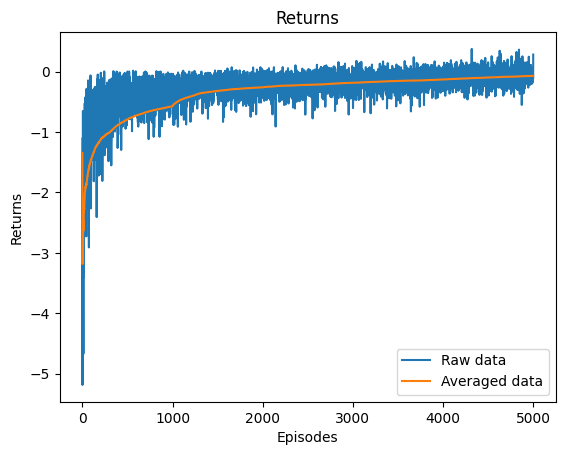

In [5]:
plt.plot(avg_rewards, label = "Raw data")
data = moving_average(data = avg_rewards, window_size=1000)
plt.plot(data, label = "Averaged data")
plt.legend()
plt.title("Returns")
plt.xlabel("Episodes")
plt.ylabel("Returns")
plt.show()